# Steps and comments

Import functions from modules. "tool" is just name for now, I haven't found a good name for it yet. 

**[functions](https://github.com/dkbrz/GSoC_2018/blob/master/tool/functions.py) **

**[evaluation](https://github.com/dkbrz/GSoC_2018/blob/master/tool/evaluation.py) **

In [1]:
from tool.functions import *
from tool.evaluation import *

**Dependencies**

Dependencies are written in file with functions

In [ ]:
import logging, sys, os, requests, json, re
from collections import Counter 
from math import exp, log10
from itertools import islice
import networkx as nx
import xml.etree.ElementTree as ET
from github import Github           #Github library for downloading dictionaries
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import matplotlib.pyplot as plt     #some evaluation (optional)
from heapdict import heapdict
from tqdm import tqdm_notebook as tqdm   #progress bar (I use notebook function because I work only here)
import random
import numpy as np, scipy.stats as st

## Loading dictionaries

Function creates a folder "dictionaries" and loads all bilingual dictionaries from Apertium Github.

**All dictionaries are on Github**

To load dictionaries, there has to be a file 'secure.json' containing:
```
{
  "USER": "<username>",
  "PASSWORD": "<password>"
}
```

In [2]:
%time download_all_bidixes()

2018-07-05 16:53:20,769 | INFO : Start
2018-07-05 17:00:39,382 | INFO : Finish
Wall time: 7min 20s


Delete some (remove = ['ces-ces.dix','ita-ita.dix', 'eus-eu_bis.dix','hbs_HR-hbs_SR.dix','zh_CN-zh_TW.dix']) dictionaries, rename those that have name that doesn't match real sides in dictionaries (list)

In [ ]:
fix_bi_dictionaries()

This one creates artificially created monolingual dictionaries that contain all bilingual etries for a particular language.

3 min

In [3]:
%time monodix()

2018-07-05 17:04:31,414 | INFO : started
2018-07-05 17:07:53,656 | INFO : finished
Wall time: 3min 22s


**There are some widgets below that can't be showed. It is just tqdm progress bar that is very useful. It will show up if you run the code.**

At this moment bilingual dictionary evaluation formula is:
    
$$ x = \frac 1{ log10( 10 + DictionaryLength )}$$

$$ Dictionary length = BothSides + 0.5 * LR + 0.5 * RL $$

So we don't go below zero as weight of the edge can't be negative

In [4]:
%time preprocessing()


Wall time: 1h 36min 36s


Now we have all we need: dictionaries and some statistical information.

## Working with language pair

Set languages that we want to work with (order like in bidix name)

In [2]:
lang1, lang2 = 'eng','spa'
n = 10

Create a file "language_list" that contains languages we can use in graph in descending order (from more useful to less useful). 

Wall time: 736 ms


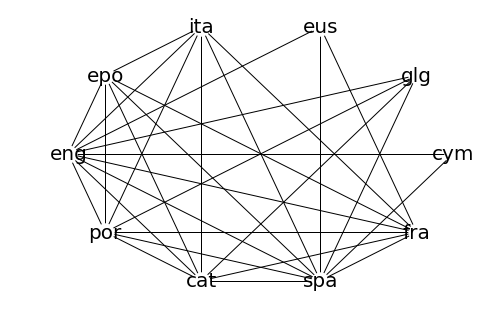

In [3]:
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [4]:
%time load_file(lang1, lang2, n=n)
%time change_encoding('{}-{}'.format(lang1,lang2))
%time G = built_from_file('{}-{}'.format(lang1,lang2))
%time l1, l2 = dictionaries(lang1, lang2)

Wall time: 2.91 s
Wall time: 790 ms
Wall time: 1min 2s
Wall time: 6.25 s


If we want to check manually, we can search by lemma.

- G: graph
- 'star' : lemma
- l1 : source language dictionary
- 'spa' : target language name
- 4 : cutoff - maximum path length (otherwise search is very slow, this parameter should be equal (or +1) to maximum path length between languages in our top-10 languages)
- 40 : number of closest candidates to evaluate
- n=5 : how many candidates to print

In [5]:
%time print_lemma_results(lemma_search (G, 'star', l1, 'spa', 4, 40), n = 5)

		 eng$star$[vblex]
spa$protagonizar$[vblex]	0.4821836326607207
spa$jugar$[vblex_vblex-vbact]	0.2840371146351084
spa$presentar$[vblex]	0.11074869476740849
spa$constar$[vblex]	0.09727280076923756
spa$tocar$[vblex]	0.0404276819945128

		 eng$star$[adj]
spa$estelar$[adj_adj-mf]	0.1268460281398451
spa$estupendo$[adj-GD_adj-GD-ND]	0.006737946999085467
spa$magnífico$[adj_adj-GD-ND_adj-GD]	0.006737946999085467

		 eng$star$[n_n-ND]
spa$estrella$[n-f_n_n-f-sg]	2.1957739681949104
spa$estelo$[n-m]	0.2712844579026809
spa$lucero$[n-m_n]	0.2712844579026809
spa$astro$[n_n-m]	0.19526883880421858
spa$estrella$[n-f-ND]	0.1470598691371015

Wall time: 300 ms


n_n-ND means that there are different tag combination for this word (n) and (n + ND) that are presumably the same (non contradictory)

Search is an optimized variant of NetworkX single_source_shortest_path_length. When we meet target language node, we stop so this saves some time. Furthermore, we take only n closest variant so this also saves a lot of time.

Formula in this example:

$$\sum_{i=1}^{number of simple paths} \exp^{-len(path_i)}$$

So we sum exponents with degree - length of simple path for all simple paths from source to target node. (And this for all n candidates). Then we sort them in descending order.

Search with larget cutoff takes a lot of time in so dense graph since we have to go furher and check all children in this subgraph

In [7]:
%time s = lemma_search (G, 'casa', l2, 'eng', 4, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 5, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 6, 40)

Wall time: 431 ms
Wall time: 2.43 s
Wall time: 15 s


## Evaluation

**How good is this instrument in translation prediction**

Loop does 1000 words (or less if dictionary is less than 1000) evaluation n_iter times to get more reliable result. It takes 1000 random words from first language that have only one translation in both sides and some alternative edges (so if we delete target edge, node won't be isolated in general graph)

- 'eng', 'spa' : languages
- n : top-n languages to include in graph
- n: how many iterations we do
- cutoff : max length path

Numbers in parentheses - the boundaries of the confidence interval

** Precision, recall, F1**

We can set topn - which places in sorted result list we consider to be relevant. 

$$ p = \frac{21-topn}{20} $$

topn= 1 would be if we want only 100% bidirectional match.

Result contains all **p** (bidirectional so 0.5 for 1->2 and 0.5 for 2->1)
```
p = p     if place is < topn  #less because 1 is 0 in Python
p = 0.01  if a right one is found but not in topn
```
```
precision = sum(1 for i in result if i >= p) / sum(1 for i in result if i > 0)
recall = sum(1 for i in result if i >= p) / sum(1 for i in result)
f1 = 2 * precision * recall / (precision + recall)
```

In [2]:
lang1, lang2, n = 'eng','spa', 10

** top-5 **

In [3]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

N= 1000	Precision : 0.9873817034700315, recall : 0.939, f1-score : 0.9625832906201948
N= 1000	Precision : 0.9804526748971193, recall : 0.953, f1-score : 0.9665314401622718
N= 1000	Precision : 0.9802083333333333, recall : 0.941, f1-score : 0.960204081632653
Wall time: 7min 26s


In [6]:
%time eval_loop(lang2, lang1, n=10, cutoff=4, n_iter=3, topn=5)

N= 1000	Precision : 0.9811912225705329, recall : 0.939, f1-score : 0.9596320899335717
N= 1000	Precision : 0.9821052631578947, recall : 0.933, f1-score : 0.956923076923077
N= 1000	Precision : 0.9895941727367326, recall : 0.951, f1-score : 0.9699133095359511

Wall time: 8min 40s


** top-1 ** only 100% match (both sides)

In [7]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

N= 1000	Precision : 0.8505747126436781, recall : 0.814, f1-score : 0.8318855390904445
N= 1000	Precision : 0.8709677419354839, recall : 0.837, f1-score : 0.8536460989291178
N= 1000	Precision : 0.8698347107438017, recall : 0.842, f1-score : 0.8556910569105691

Wall time: 8min 54s


In [8]:
%time eval_loop(lang2, lang1, n=10, cutoff=4, n_iter=3, topn=1)

N= 1000	Precision : 0.8465553235908142, recall : 0.811, f1-score : 0.8283963227783452
N= 1000	Precision : 0.8492146596858638, recall : 0.811, f1-score : 0.8296675191815857
N= 1000	Precision : 0.8454258675078864, recall : 0.804, f1-score : 0.8241927216811892

Wall time: 8min 39s


** We can change cutoffs (slower) and number of languages **

** top-5 **

In [9]:
%time eval_loop(lang1, lang2, n=10, cutoff=6, n_iter=3, topn=5)

N= 1000	Precision : 0.9823284823284824, recall : 0.945, f1-score : 0.963302752293578
N= 1000	Precision : 0.9794238683127572, recall : 0.952, f1-score : 0.9655172413793104
N= 1000	Precision : 0.979253112033195, recall : 0.944, f1-score : 0.9613034623217922

Wall time: 8min 59s


In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=4, n_iter=3, topn=5)

N= 1000	Precision : 0.9768664563617245, recall : 0.929, f1-score : 0.9523321373654537


** top-1 **

In [3]:
%time eval_loop(lang1, lang2, n=10, cutoff=6, n_iter=3, topn=1)

N= 1000	Precision : 0.8393782383419689, recall : 0.81, f1-score : 0.8244274809160306
N= 1000	Precision : 0.8429926238145417, recall : 0.8, f1-score : 0.8209338122113905
N= 1000	Precision : 0.8552223371251293, recall : 0.827, f1-score : 0.8408744280630401

Wall time: 7min 25s


In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=4, n_iter=3, topn=1)

In [ ]:
%time eval_loop(lang1, lang2, n=15, cutoff=6, n_iter=3, topn=1)

# RUS-UKR

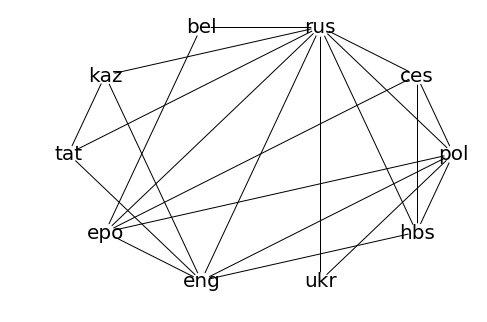

In [2]:
lang1, lang2 = 'rus','ukr'
n = 10
get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [3]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

N= 1000	Precision : 0.9636363636363636, recall : 0.689, f1-score : 0.8034985422740525
N= 1000	Precision : 0.9656121045392022, recall : 0.702, f1-score : 0.8129704690214243
N= 1000	Precision : 0.9654218533886584, recall : 0.698, f1-score : 0.8102147417295413
Wall time: 4min 4s


In [4]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

N= 1000	Precision : 0.6961325966850829, recall : 0.504, f1-score : 0.5846867749419953
N= 1000	Precision : 0.689608636977058, recall : 0.511, f1-score : 0.5870189546237794
N= 1000	Precision : 0.6958904109589041, recall : 0.508, f1-score : 0.5872832369942197
Wall time: 4min 1s


# BEL-RUS

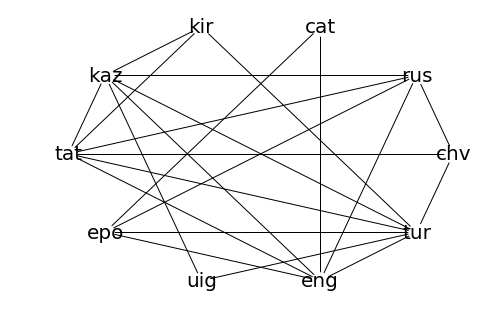

In [5]:
lang1, lang2 = 'tur','tat'
n = 10
get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [6]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=5)

N= 508	Precision : 0.8832807570977917, recall : 0.5511811023622047, f1-score : 0.6787878787878787
N= 508	Precision : 0.8832807570977917, recall : 0.5511811023622047, f1-score : 0.6787878787878787
N= 508	Precision : 0.8832807570977917, recall : 0.5511811023622047, f1-score : 0.6787878787878787
Wall time: 3min 23s


Same results occur because we have only 502 word that fit our "rules"

In [7]:
%time eval_loop(lang1, lang2, n=10, cutoff=4, n_iter=3, topn=1)

N= 508	Precision : 0.6782334384858044, recall : 0.42322834645669294, f1-score : 0.5212121212121213
N= 508	Precision : 0.6750788643533123, recall : 0.421259842519685, f1-score : 0.5187878787878788
N= 508	Precision : 0.6750788643533123, recall : 0.421259842519685, f1-score : 0.5187878787878788
Wall time: 3min 15s


In [ ]:
addition(lang1, lang2, n=10, cutoff=4)

## Weighted edges

I added weighted edges (like in language ranking) but it doesn't seem to work better.

$$ weight[lang1 lang2] =  \frac{1}{log10(10+bidirectional+LR}$$
$$ weight[lang2 lang1] =  \frac{1}{log10(10+bidirectional+RL}$$

I didn't included it in functions. 


This doesn't work better because if there is a link than it it good and it doesn't depend on how good languages pair is (ffrom which we took this edge). So at this point every edge is equal.

## How many entries we can possibly add?

It took 18 hours to calculate all bilingual dictionaries

**How many entries we can add**

Addition says how many entries we can add. (portion of all bilingual entries). I don't know how many make sense, but this number shows how many have at least one candidate (with this cutoff) for translation in other language. 

- exist :  there is a translation in bilingual dictionary
- failed : we can't find any path to target language (at least with this cutoff, with longer paths translation can be worse)
- new : there is at least one candidate for being a translation for some word that has no translation in bilingual dictionary
- NA : word in not in a dictionary (there is this node in monodix but not in this 10 language graph)

In [4]:
with open('./files/second.csv', 'r', encoding='utf-8') as inp:
    for line in tqdm(inp.readlines()):
        data = line.split()
        if data[2] != '0' and data[2] != 0:
            addition2(data[0],data[1])

fin->eng	Exist: 85966, failed: 1062, NEW: 1411 +2.0%, NA: 13442
eng->fin	Exist: 107803, failed: 27120, NEW: 5532 +5.0%, NA: 101107
ita->nor	Exist: 24018, failed: 26912, NEW: 5351 +22.0%, NA: 7546
nor->ita	Exist: 28809, failed: 45951, NEW: 6898 +24.0%, NA: 14432
eng->gle	Exist: 51512, failed: 80638, NEW: 30681 +60.0%, NA: 78731
gle->eng	Exist: 44174, failed: 22, NEW: 100 +0.0%, NA: 6665
sme->nob	Exist: 72697, failed: 13853, NEW: 1903 +3.0%, NA: 6569
nob->sme	Exist: 63420, failed: 4066, NEW: 1120 +2.0%, NA: 39717
swe->nor	Exist: 53532, failed: 9088, NEW: 6862 +13.0%, NA: 3115
nor->swe	Exist: 57651, failed: 14550, NEW: 20768 +36.0%, NA: 3121
nno->nob	Exist: 64750, failed: 20, NEW: 0 +0.0%, NA: 790
nob->nno	Exist: 58944, failed: 45, NEW: 0 +0.0%, NA: 49334
sme->smn	Exist: 54263, failed: 1, NEW: 0 +0.0%, NA: 40758
smn->sme	Exist: 52648, failed: 2, NEW: 0 +0.0%, NA: 1
dan->nor	Exist: 42656, failed: 2376, NEW: 1757 +4.0%, NA: 1635
nor->dan	Exist: 47825, failed: 27017, NEW: 18127 +38.0%, NA: 3

ita->cos	Exist: 3731, failed: 40839, NEW: 13439 +360.0%, NA: 5818
eng->srn	Exist: 3871, failed: 0, NEW: 0 +0.0%, NA: 237691
srn->eng	Exist: 3078, failed: 0, NEW: 0 +0.0%, NA: 0
chv->tat	Exist: 4658, failed: 6630, NEW: 4472 +96.0%, NA: 4
tat->chv	Exist: 4483, failed: 14796, NEW: 2604 +58.0%, NA: 687
hbs->rus	Exist: 4118, failed: 6112, NEW: 6666 +162.0%, NA: 6016
rus->hbs	Exist: 4911, failed: 30913, NEW: 13446 +274.0%, NA: 28647
deu->ltz	Exist: 4537, failed: 0, NEW: 0 +0.0%, NA: 63593
ltz->deu	Exist: 4687, failed: 0, NEW: 0 +0.0%, NA: 0
fin->fkv	Exist: 4402, failed: 0, NEW: 0 +0.0%, NA: 97479
fkv->fin	Exist: 4443, failed: 0, NEW: 0 +0.0%, NA: 0
urd->hin	Exist: 4457, failed: 2, NEW: 123 +3.0%, NA: 0
hin->urd	Exist: 4196, failed: 63, NEW: 23 +1.0%, NA: 40037
spa->qve	Exist: 3954, failed: 39, NEW: 0 +0.0%, NA: 134846
qve->spa	Exist: 3885, failed: 71, NEW: 0 +0.0%, NA: 2
epo->swe	Exist: 3608, failed: 73014, NEW: 31923 +885.0%, NA: 73704
swe->epo	Exist: 3437, failed: 46125, NEW: 16768 +488.0%

zul->xho	Exist: 4, failed: 0, NEW: 0 +0.0%, NA: 2
xho->zul	Exist: 4, failed: 0, NEW: 0 +0.0%, NA: 0
tlh->swe	Exist: 3, failed: 0, NEW: 0 +0.0%, NA: 0
swe->tlh	Exist: 3, failed: 0, NEW: 0 +0.0%, NA: 72594
fin->krl	Exist: 2, failed: 407, NEW: 0 +0.0%, NA: 101472
krl->fin	Exist: 2, failed: 21, NEW: 1 +50.0%, NA: 0
zul->ssw	Exist: 0, failed: 0, NEW: 0 +0%, NA: 6
ssw->zul	Exist: 0, failed: 0, NEW: 0 +0%, NA: 2
eng->tel	Exist: 1, failed: 26289, NEW: 0 +0.0%, NA: 215272
tel->eng	Exist: 1, failed: 0, NEW: 0 +0.0%, NA: 0
liv->fin	Exist: 1, failed: 0, NEW: 0 +0.0%, NA: 0
fin->liv	Exist: 1, failed: 0, NEW: 0 +0.0%, NA: 101880
sme->spa	Exist: 1, failed: 10219, NEW: 7573 +757300.0%, NA: 77229
spa->sme	Exist: 1, failed: 92211, NEW: 16016 +1601600.0%, NA: 30611
tel->mar	Exist: 1, failed: 0, NEW: 0 +0.0%, NA: 0
mar->tel	Exist: 1, failed: 15606, NEW: 0 +0.0%, NA: 8

